<a href="https://colab.research.google.com/github/katoyu/image-processing-100training/blob/master/%E7%94%BB%E5%83%8F%E5%87%A6%E7%90%86100%E6%9C%AC%E3%83%8E%E3%83%83%E3%82%AF41_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!wget https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/Question_41_50/imori.jpg
!wget https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/Question_41_50/thorino.jpg
  
from google.colab.patches import cv2_imshow

--2019-04-22 15:19:53--  https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/Question_41_50/imori.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12638 (12K) [image/jpeg]
Saving to: ‘imori.jpg.1’

imori.jpg.1         100%[===================>]  12.34K  --.-KB/s    in 0s      

2019-04-22 15:19:53 (116 MB/s) - ‘imori.jpg.1’ saved [12638/12638]

--2019-04-22 15:19:55--  https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/Question_41_50/thorino.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27023 (26K) [i

#41 Cannyエッジ検出 (Step.1) エッジ強度

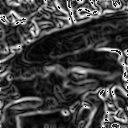

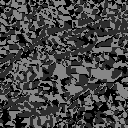

In [4]:
import cv2
import numpy as np

img = cv2.imread("imori.jpg").astype(np.float32)
H, W, C = img.shape
#1. グレースケール
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

#2. gaussianフィルタ 5x5 s=1.4
K_size = 5
sigma = 1.4

##zero padding
pad = K_size // 2
gau = np.zeros((H + pad*2, W + pad*2), dtype=np.float32)
gau = np.pad(gray, (pad, pad), 'edge')
tmp = gau.copy()

##Karnel
K = np.zeros((K_size, K_size), dtype=np.float32)
for x in range(-pad, -pad+K_size):
    for y in range(-pad, -pad+K_size):
           K[y+pad, x+pad] = np.exp( -(x**2 + y**2) / (2 * (sigma**2)))
            
K /= (sigma * np.sqrt(2 * np.pi))
K /= K.sum()

#3. x,y方向のSobelフィルタをかけ、画像の購買画像fx,fyを求め、勾配強度と勾配角度を次式で求める

for y in range(H):
    for x in range(W):
        gau[pad+y, pad+x] = np.sum(K * tmp[y:y+K_size, x:x+K_size])
        
##Sobel vertical
KSV = np.array(((-1., -2., -1.), (0., 0., 0.), (1., 2., 1.)), dtype=np.float32)
##Sobel horizontal
KSH = np.array(((-1., 0., 1.), (-2., 0., 2.), (-1., 0., 1.)), dtype=np.float32)

gau = gau[pad-1:H+pad+1, pad-1:W+pad+1]
fy = np.zeros_like(gau, dtype=np.float32)
fx  =np.zeros_like(gau, dtype=np.float32)
K_size = 3
pad = K_size//2

for y in range(H):
    for x in range(W):
        fy[pad+y, pad+x] = np.sum(KSV * gau[y:y+K_size, x:x+K_size])
        fx[pad+y, pad+x] = np.sum(KSH * gau[y:y+K_size, x:x+K_size])

fx = fx[pad:pad+H, pad:pad+W]
fy = fy[pad:pad+H, pad:pad+W]

# Non-maximum suppression

edge = np.sqrt(fx**2 + fy**2)

out1 = edge.astype(np.uint8)
cv2_imshow(out1)

fx[fx==0] = 1e-5
tan = np.arctan(fy/ fx)


#4. ヒステリシスによる閾値処理

angle = np.zeros_like(tan, dtype=np.uint8)
angle[np.where((tan > -0.4142) & (tan <= 0.4142))] = 0
angle[np.where((tan > 0.4142 ) & (tan  <2.4142))] = 45
angle[np.where((np.abs(tan)) >= 2.4142)] = 90
angle[np.where((tan > -2.4142) & (tan <= -0.4142))] = 135

out2 = angle.astype(np.uint8)

cv2_imshow(out2)

#42 Cannyエッジ検出 (Step.2) 細線化

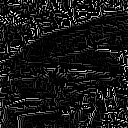

In [8]:
#41からの続き
for y in range(H):
    for x in range(W):
        if angle[y, x] == 0:
            dx1, dy1, dx2, dy2 = -1, 0, 1, 0
        elif angle[y, x] == 45:
            dx1, dy1, dx2, dy2 = -1, 1, 1, -1
        elif angle[y, x] == 90:
            dx1, dy1, dx2, dy2 = 0, -1, 0, 1
        elif angle[y, x] == 135:
            dx1, dy1, dx2, dy2 = -1, -1, 1, 1
        if x == 0:
            dx1 = max(dx1, 0)
            dx2 = max(dx2, 0)
        if x == W-1:
            dx1 = min(dx1, 0)
            dx2 = min(dx2, 0)
        if y == 0:
            dy1 = max(dy1, 0)
            dy2 = max(dy2, 0)
        if y == H-1:
            dy1 = min(dy1, 0)
            dy2 = min(dy2, 0)
        if max(max(edge[y, x], edge[y+dy1, x+dx1]), edge[y+dy2, x+dx2]) != edge[y, x]:
            edge[y, x] = 0

out = edge.astype(np.uint8)
cv2_imshow(out)

#43 Cannyエッジ検出 (Step.3) ヒステリシス閾処理


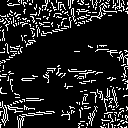

In [11]:
#41,42から続き

HT = 100
LT = 30

edge[edge >= HT] = 255
edge[edge <= LT] = 0

_edge = np.zeros((H+2, W+2), dtype=np.float32)
_edge[1:H+1, 1:W+1] = edge

# 8 -nearest neighbor
nn = np.array(((1., 1., 1.), (1., 0., 1.), (1., 1., 1.)), dtype=np.float32)

for y in range(1, H+2):
    for x in range(1, W+2):

        if _edge[y, x] < LT or _edge[y, x] > HT:
            continue
        if np.max(_edge[y-1:y+2, x-1:x+2]*nn) >= HT:
            _edge[y, x] = 255
        else:
            _edge[y, x] = 0
edge = _edge[1:H+1, 1:W+1]

out = edge.astype(np.uint8)

cv2_imshow(out)
